# Single Subject GLM Analysis using the Localizer dataset

In this lab, extend your work from the previous lab to work with 3D brain data. The preprocessed data of the first subject in the localizer study is included.

In [23]:
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import nibabel as nib

Load the functional image of the first subject.

In [24]:
data = nib.load('preprocessed_fMRI_bold.nii.gz')

We should get a sequence of 128 frames of 3D images of the shape (53, 63, 46).

In [25]:
data.get_fdata().shape

(53, 63, 46, 128)

Let's plot a few brain slices just to check if we are actually seeing some brain.

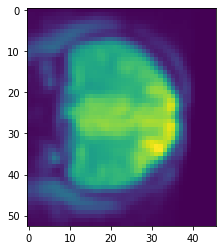

In [26]:
plt.imshow(data.get_fdata()[:,50,:,0])

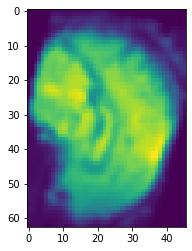

In [27]:
plt.imshow(data.get_fdata()[25,:,:,0])

Let's load the mask data for this subject.

In [28]:
mask = nib.load('./sub-S01_mask.nii.gz')

The shape of the mask data should be identical to that of a signle frame in the brain data.

In [32]:
mask.get_fdata().shape

(53, 63, 46)

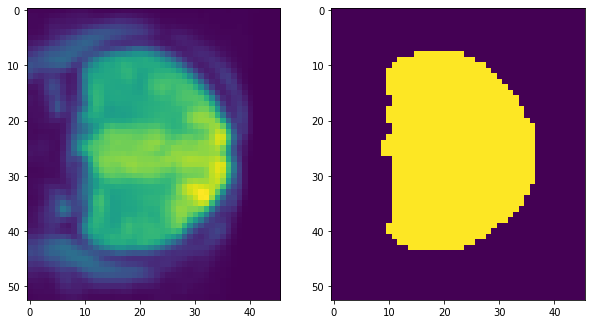

In [30]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(data.get_fdata()[:,50,:,0])
plt.subplot(1,2,2)
plt.imshow(mask.get_fdata()[:,50,:])

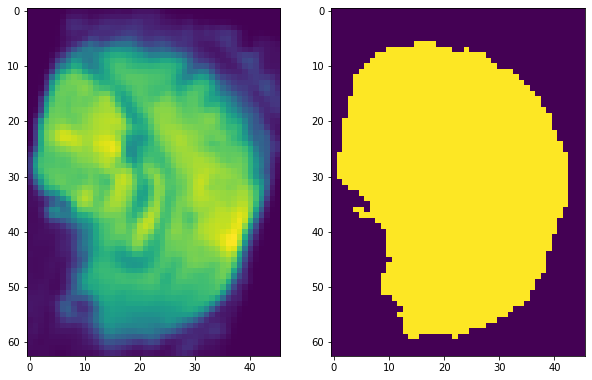

In [31]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(data.get_fdata()[25,:,:,0])
plt.subplot(1,2,2)
plt.imshow(mask.get_fdata()[25,:,:])

# Exercise 

For each of the question below, use your code to perform the analysis.

## Which regions are more involved with visual compared to auditory sensory processing?

## Which regions are more involved in processing numbers compared to words?

## Which regions are more involved with motor compared to cognitive processes (e.g., language and math)?